##### Imports

In [14]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime


In [15]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"

In [16]:
driver = GraphDatabase.driver(uri, auth=(username, password))

##### Number of Batches

In [17]:
cypher_total_batch_number = """
    MATCH (n:BatchInstance)
    RETURN count (distinct n)
"""


def total_batches(uri, username, password, cypher_total_batch_number):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_total_batch_number)
        data = result.data()
        return data
    
results_total_batches = total_batches(uri, username, password, cypher_total_batch_number)
print(results_total_batches) 

[{'count (distinct n)': 53646}]


##### Average, MIN and MAX Amount of Kits in a Batch
Remove the outliers

In [18]:
cypher_avg_kits_in_batch = """
    MATCH (n:BatchInstance)
    RETURN AVG(size(n.kits)) AS average_kits_per_batch,
        MIN(size(n.kits)) AS min_kits_per_batch,
        MAX(size(n.kits)) AS max_kits_per_batch
"""


def avg_kits_in_batch(uri, username, password, cypher_avg_kits_in_batch):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_avg_kits_in_batch)
        data = result.data()
        return data
    
results_avg_kits_in_batch = avg_kits_in_batch(uri, username, password, cypher_avg_kits_in_batch)
print(results_avg_kits_in_batch) 

[{'average_kits_per_batch': 2.944171047235585, 'min_kits_per_batch': 1, 'max_kits_per_batch': 123}]


[{'number_kits': 1, 'frequency': 34278}, {'number_kits': 11, 'frequency': 427}, {'number_kits': 5, 'frequency': 1089}, {'number_kits': 8, 'frequency': 613}, {'number_kits': 3, 'frequency': 3246}, {'number_kits': 15, 'frequency': 262}, {'number_kits': 10, 'frequency': 522}, {'number_kits': 2, 'frequency': 6927}, {'number_kits': 25, 'frequency': 46}, {'number_kits': 12, 'frequency': 433}, {'number_kits': 13, 'frequency': 368}, {'number_kits': 14, 'frequency': 279}, {'number_kits': 23, 'frequency': 48}, {'number_kits': 7, 'frequency': 625}, {'number_kits': 24, 'frequency': 56}, {'number_kits': 4, 'frequency': 1693}, {'number_kits': 9, 'frequency': 597}, {'number_kits': 6, 'frequency': 766}, {'number_kits': 46, 'frequency': 11}, {'number_kits': 22, 'frequency': 56}, {'number_kits': 31, 'frequency': 20}, {'number_kits': 28, 'frequency': 29}, {'number_kits': 16, 'frequency': 189}, {'number_kits': 56, 'frequency': 5}, {'number_kits': 27, 'frequency': 28}, {'number_kits': 17, 'frequency': 197}

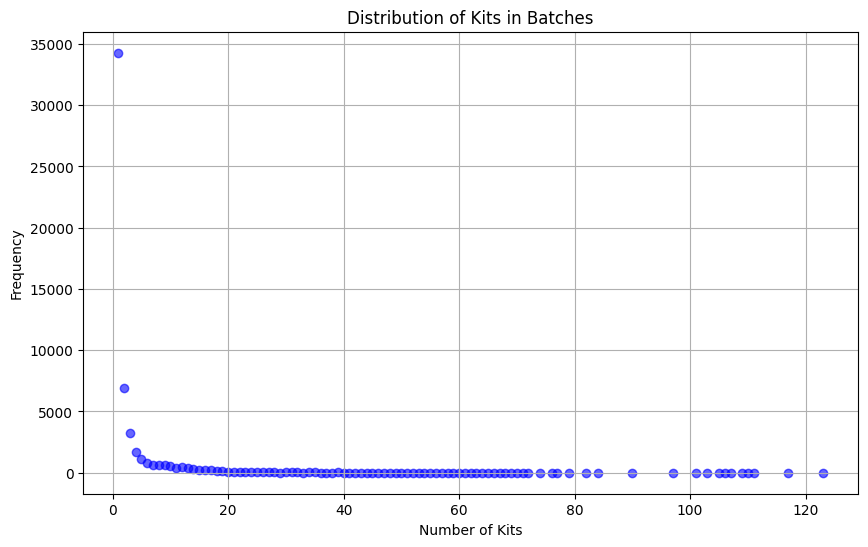

In [19]:
cypher_kits_in_batch_distribution = """
    MATCH (n:BatchInstance)
    WITH size(n.kits) AS number_kits
    RETURN number_kits, count(number_kits) AS frequency 
"""
def kits_in_batch_distribution(uri, username, password, cypher_kits_in_batch_distribution):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_kits_in_batch_distribution)
        data = result.data()
        return data
    
results_kits_in_batch_distribution = avg_kits_in_batch(uri, username, password, cypher_kits_in_batch_distribution)
print(results_kits_in_batch_distribution) 

number_kits = [record['number_kits'] for record in results_kits_in_batch_distribution]
frequency = [record['frequency'] for record in results_kits_in_batch_distribution]

plt.figure(figsize=(10, 6))
plt.scatter(number_kits, frequency,  color='blue', alpha=0.6)
plt.title('Distribution of Kits in Batches')
plt.xlabel('Number of Kits')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### Batch Frequency per Activity
+ consider size of the batches

[{'activity': 'Montaje', 'batch_count': 17932}, {'activity': 'Producción  montada', 'batch_count': 17897}, {'activity': 'Cargado en carro  L+D', 'batch_count': 6661}, {'activity': 'Carga L+D iniciada', 'batch_count': 2386}, {'activity': 'Composición de cargas', 'batch_count': 2230}, {'activity': 'Entrada Material Sucio', 'batch_count': 2128}, {'activity': 'Carga L+D liberada', 'batch_count': 1790}, {'activity': 'Carga de esterilizador liberada', 'batch_count': 1407}, {'activity': 'Comisionado', 'batch_count': 1215}]


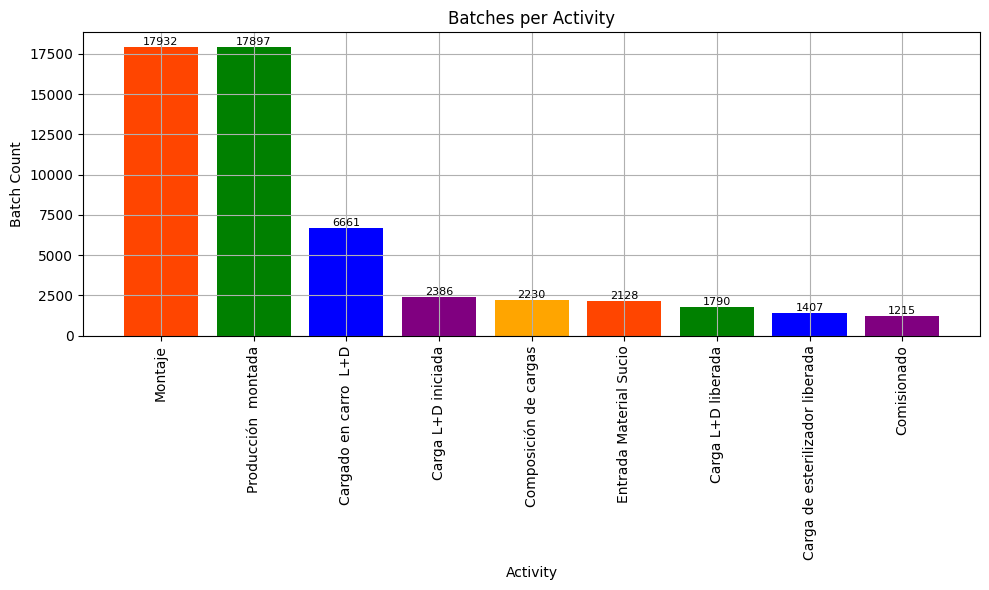

In [7]:
cypher_batches_per_activity = """
    MATCH (n:BatchInstance)
    RETURN n.activity as activity, count(n) AS batch_count
    ORDER BY batch_count DESC
"""


def batches_per_activity(uri, username, password, cypher_batches_per_activity):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_batches_per_activity)
        data = result.data()
        return data
    
results_batches_per_activity = avg_kits_in_batch(uri, username, password, cypher_batches_per_activity)
print(results_batches_per_activity) 

#Plot
activity = [str(row['activity']) for row in results_batches_per_activity]
batch_counts = [row['batch_count'] for row in results_batches_per_activity]

colors = ['orangered', 'green', 'blue', 'purple', 'orange']  # Add more colors as needed

plt.figure(figsize=(10, 6))
bars = plt.bar(activity, batch_counts, color=colors)

plt.title('Batches per Activity')
plt.xlabel('Activity')
plt.ylabel('Batch Count')

plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=10)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()

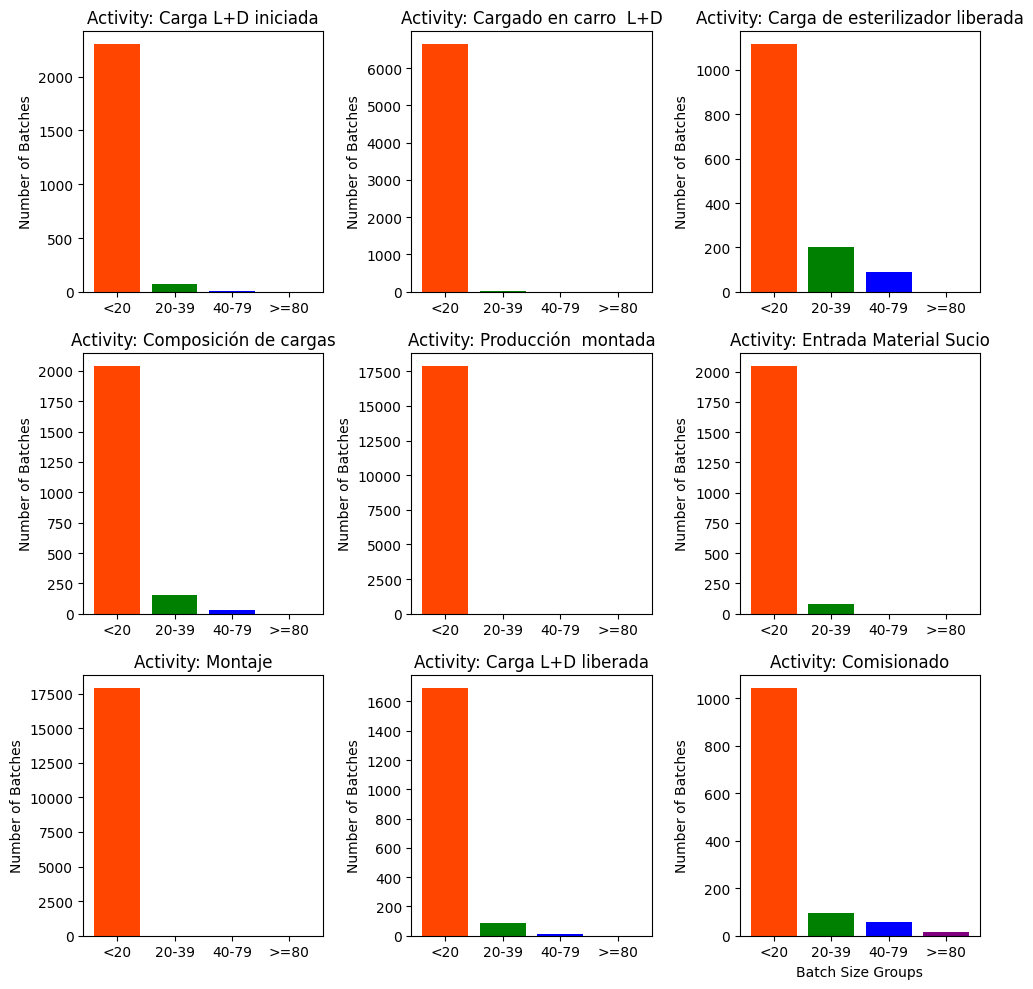

In [20]:
cypher_batches_per_activity = """
    MATCH (n:BatchInstance)
    WITH n.activity AS activity, size(n.kits) AS batch_size
    RETURN activity, 
           sum(CASE WHEN batch_size < 20 THEN 1 ELSE 0 END) AS kits_lt_20,
           sum(CASE WHEN batch_size >= 20 AND batch_size < 40 THEN 1 ELSE 0 END) AS kits_20_39,
           sum(CASE WHEN batch_size >= 40 AND batch_size < 80 THEN 1 ELSE 0 END) AS kits_40_79,
           sum(CASE WHEN batch_size >= 80 THEN 1 ELSE 0 END) AS kits_gt_80
"""

def batches_per_activity(uri, username, password, cypher_query):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_query)
        data = result.data()
        return data
    

results_batches_per_activity = batches_per_activity(uri, username, password, cypher_batches_per_activity)


activities = [row['activity'] for row in results_batches_per_activity]
kits_lt_20 = [row['kits_lt_20'] for row in results_batches_per_activity]
kits_20_39 = [row['kits_20_39'] for row in results_batches_per_activity]
kits_40_79 = [row['kits_40_79'] for row in results_batches_per_activity]
kits_gt_80 = [row['kits_gt_80'] for row in results_batches_per_activity]


colors = ['orangered', 'green', 'blue', 'purple']


fig, axs = plt.subplots(3, 3, figsize=(10, 10))


for i, activity in enumerate(activities):
    row = i // 3
    col = i % 3
    axs[row, col].bar(['<20', '20-39', '40-79', '>=80'],
                      [kits_lt_20[i], kits_20_39[i], kits_40_79[i], kits_gt_80[i]],
                      color=colors)
    axs[row, col].set_title(f'Activity: {activity}')
    axs[row, col].set_ylabel('Number of Batches')

plt.xlabel('Batch Size Groups')
plt.tight_layout()
plt.show()


##### Average, MAX and MIN Batch Processing Time 
+ distribution chart +activity and batch size (scatter plot)

In [21]:
cypher_query_average_processing_time_per_batch = """
    MATCH (n:BatchInstance)
    RETURN AVG(datetime(n.latest_timestamp).epochMillis - datetime(n.earliest_timestamp).epochMillis)/60000 AS avg_processing_time_ms,
        MIN(datetime(n.latest_timestamp).epochMillis - datetime(n.earliest_timestamp).epochMillis)/60000 AS min_processing_time_ms,
        MAX(datetime(n.latest_timestamp).epochMillis - datetime(n.earliest_timestamp).epochMillis)/60000 AS max_processing_time_ms
"""


def average_processing_time_per_batch(uri, username, password, cypher_query_average_processing_time_per_batch):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_query_average_processing_time_per_batch)
        data = result.data()
        return data
    
results_average_processing_time_per_batch = average_processing_time_per_batch(uri, username, password, cypher_query_average_processing_time_per_batch)
print(results_average_processing_time_per_batch) 


[{'avg_processing_time_ms': 0.09825522872161926, 'min_processing_time_ms': 0, 'max_processing_time_ms': 12}]


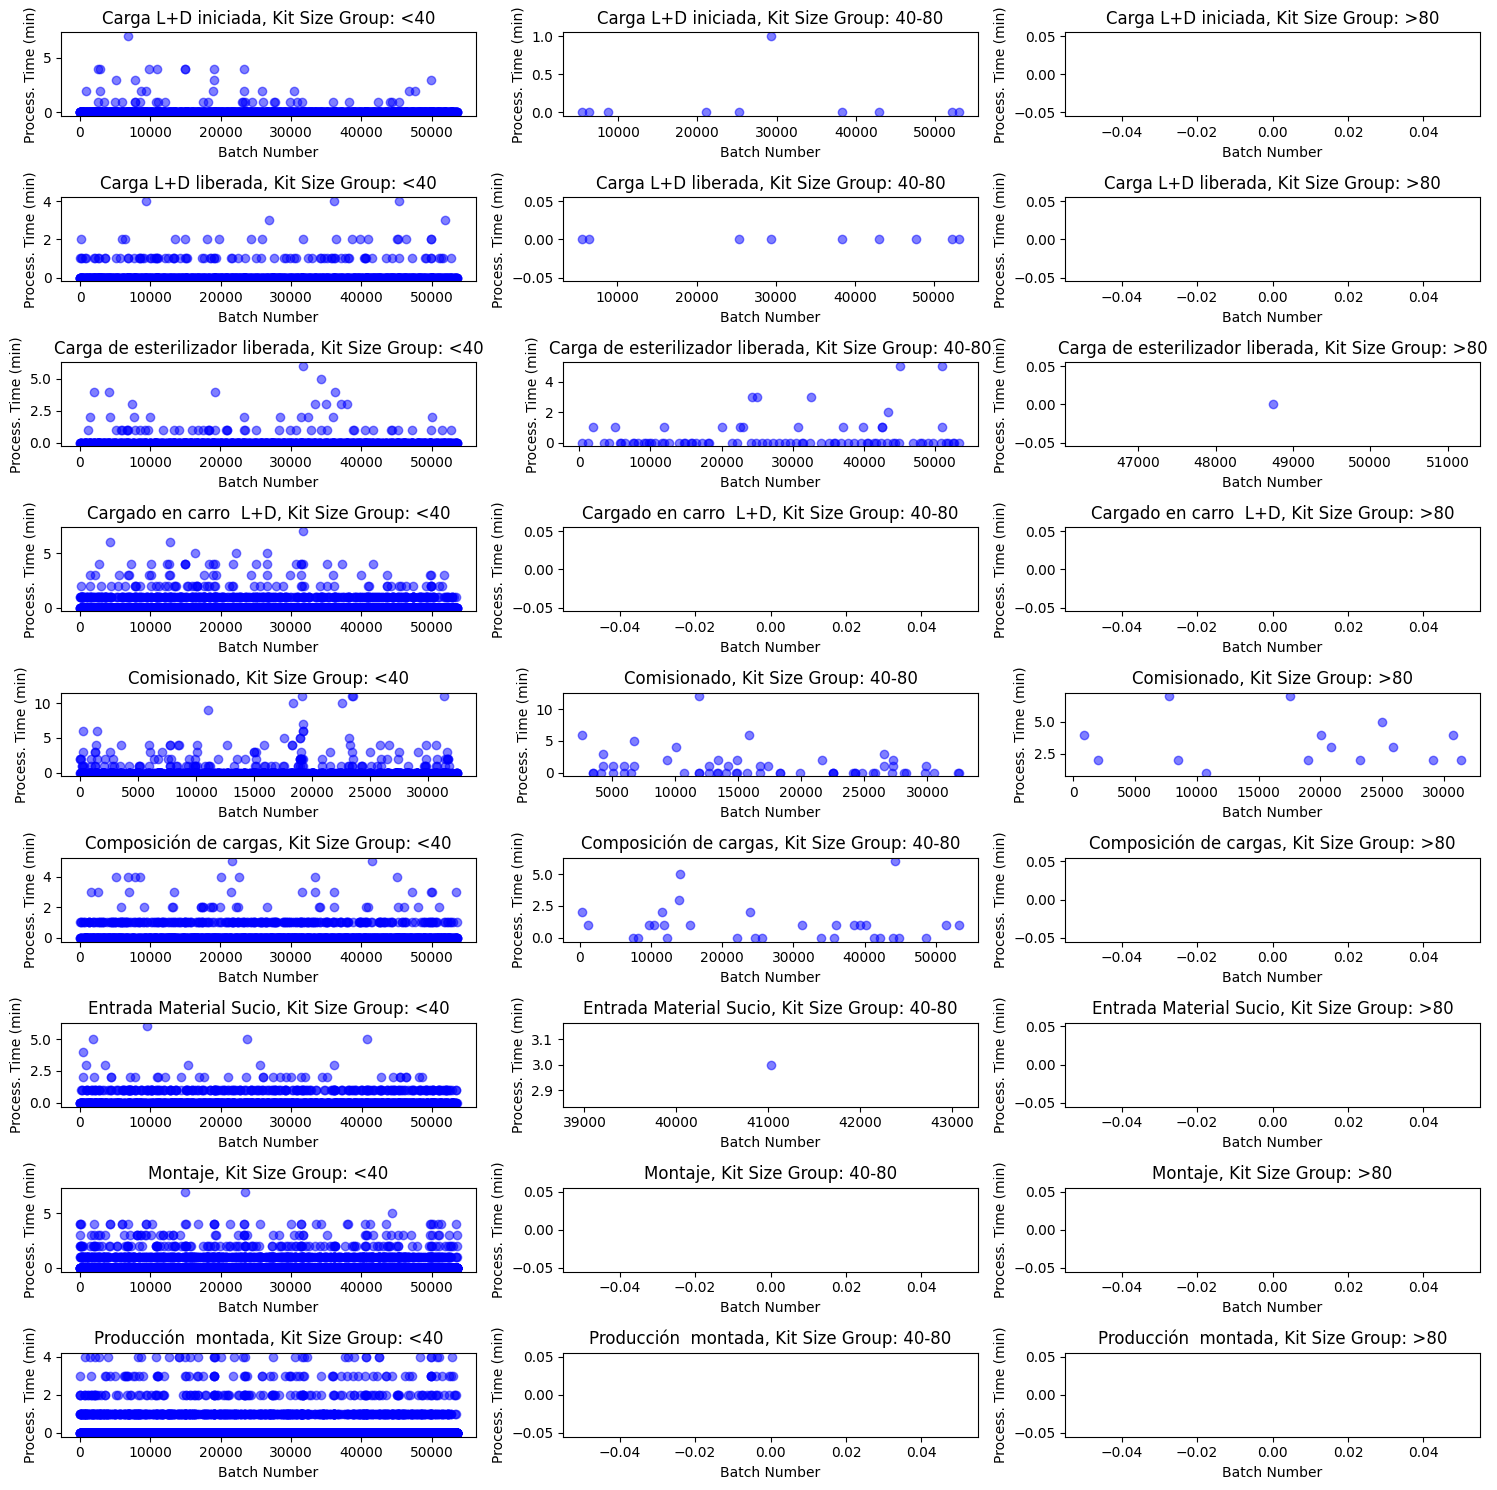

In [22]:
cypher_query_average_processing_time_per_batch = """
    MATCH (n:BatchInstance)
    WITH n, (datetime(n.latest_timestamp).epochMillis - datetime(n.earliest_timestamp).epochMillis)/60000 AS processing_time_min,
         size(n.kits) AS kit_size
    RETURN n.activity AS activity,
           n.batch_number AS batch_number, 
           processing_time_min,
           CASE WHEN kit_size < 40 THEN '<40'
                WHEN kit_size >= 40 AND kit_size <= 80 THEN '40-80'
                ELSE '>80' END AS kit_size_group
"""


def average_processing_time_per_batch(uri, username, password, cypher_query):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_query)
        data = result.data()
        return data

results_average_processing_time_per_batch = average_processing_time_per_batch(uri, username, password, cypher_query_average_processing_time_per_batch)


activities = set(row['activity'] for row in results_average_processing_time_per_batch)
kit_size_groups = ['<40', '40-80', '>80']


fig, axs = plt.subplots(len(activities), len(kit_size_groups), figsize=(15, 15))


for i, activity in enumerate(sorted(activities)):
    for j, kit_size_group in enumerate(kit_size_groups):
   
        filtered_data = [(row['batch_number'], row['processing_time_min']) for row in results_average_processing_time_per_batch 
                         if row['activity'] == activity and row['kit_size_group'] == kit_size_group]

        x_values = [entry[0] for entry in filtered_data]
        y_values = [entry[1] for entry in filtered_data]
     
        axs[i, j].scatter(x_values, y_values, color='blue', alpha=0.5)
        axs[i, j].set_title(f'{activity}, Kit Size Group: {kit_size_group}')
        axs[i, j].set_xlabel('Batch Number')
        axs[i, j].set_ylabel('Process. Time (min)')

plt.tight_layout()
plt.show()



##### Throughput of Batches per Day


[{'day': neo4j.time.Date(2022, 1, 1), 'batch_count': 117}, {'day': neo4j.time.Date(2022, 1, 2), 'batch_count': 141}, {'day': neo4j.time.Date(2022, 1, 3), 'batch_count': 647}, {'day': neo4j.time.Date(2022, 1, 4), 'batch_count': 527}, {'day': neo4j.time.Date(2022, 1, 5), 'batch_count': 563}, {'day': neo4j.time.Date(2022, 1, 6), 'batch_count': 114}, {'day': neo4j.time.Date(2022, 1, 7), 'batch_count': 496}, {'day': neo4j.time.Date(2022, 1, 8), 'batch_count': 116}, {'day': neo4j.time.Date(2022, 1, 9), 'batch_count': 149}, {'day': neo4j.time.Date(2022, 1, 10), 'batch_count': 636}, {'day': neo4j.time.Date(2022, 1, 11), 'batch_count': 743}, {'day': neo4j.time.Date(2022, 1, 12), 'batch_count': 848}, {'day': neo4j.time.Date(2022, 1, 13), 'batch_count': 867}, {'day': neo4j.time.Date(2022, 1, 14), 'batch_count': 740}, {'day': neo4j.time.Date(2022, 1, 15), 'batch_count': 152}, {'day': neo4j.time.Date(2022, 1, 16), 'batch_count': 147}, {'day': neo4j.time.Date(2022, 1, 17), 'batch_count': 754}, {'day

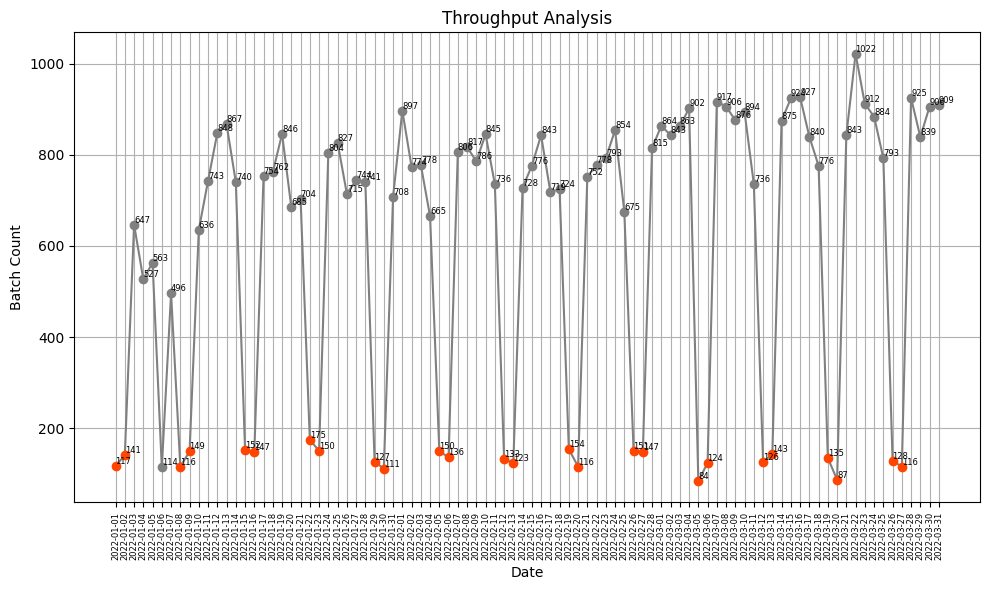

In [23]:
cypher_throughput_analysis = """
    MATCH (n:BatchInstance)
    WITH n, date(n.earliest_timestamp) AS day
    RETURN day,
           count(n) AS batch_count
    ORDER BY day
"""


def throughput_analysis(uri, username, password, cypher_throughput_analysis):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_throughput_analysis)
        data = result.data()
        return data
    
results_throughput_analysis = throughput_analysis(uri, username, password, cypher_throughput_analysis)
print(results_throughput_analysis) 


# Plot
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming results_throughput_analysis is a list of dictionaries with keys 'day' and 'batch_count'

# Get the days and batch counts
days = [str(row['day']) for row in results_throughput_analysis]
batch_counts = [row['batch_count'] for row in results_throughput_analysis]

# Convert string dates to datetime objects to check if they're weekdays or weekends
dates = [datetime.strptime(day, '%Y-%m-%d') for day in days]

plt.figure(figsize=(10, 6))

# Plot all points as nodes
for i in range(len(days) - 1):
    current_day = days[i]
    next_day = days[i + 1]
    current_count = batch_counts[i]
    next_count = batch_counts[i + 1]
    plt.plot([current_day, next_day], [current_count, next_count], color='gray')  # Line connecting consecutive days

# Plot nodes for weekdays and weekends
for i, date in enumerate(dates):
    if date.weekday() < 5:  # Weekdays
        plt.scatter(days[i], batch_counts[i], color='gray', zorder=3)  
    else:  # Weekends
        plt.scatter(days[i], batch_counts[i], color='orangered', zorder=3)  

plt.title('Throughput Analysis')
plt.xlabel('Date')
plt.ylabel('Batch Count')

plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=6)  

for i, txt in enumerate(batch_counts):
    plt.annotate(txt, (days[i], batch_counts[i]), fontsize=6, ha='left', va='bottom')

plt.grid(True)
plt.tight_layout()
plt.show()



#### Resource Related Analytics

##### Batches per Resource
+schedule of the users

[{'resource': 'MCE', 'batch_count': 5550}, {'resource': 'ER', 'batch_count': 4756}, {'resource': 'PN', 'batch_count': 4650}, {'resource': 'SM', 'batch_count': 4610}, {'resource': 'EH', 'batch_count': 3822}, {'resource': 'AV', 'batch_count': 3793}, {'resource': 'BM', 'batch_count': 3723}, {'resource': 'PG', 'batch_count': 3617}, {'resource': 'CM', 'batch_count': 2934}, {'resource': 'VS', 'batch_count': 2716}, {'resource': 'MMF', 'batch_count': 2565}, {'resource': 'LI', 'batch_count': 2005}, {'resource': 'ML', 'batch_count': 1984}, {'resource': 'CLE', 'batch_count': 1769}, {'resource': 'MR', 'batch_count': 1700}, {'resource': 'SP', 'batch_count': 1624}, {'resource': 'VA', 'batch_count': 1519}, {'resource': 'MAA', 'batch_count': 290}, {'resource': 'DF', 'batch_count': 10}, {'resource': 'MGP', 'batch_count': 9}]


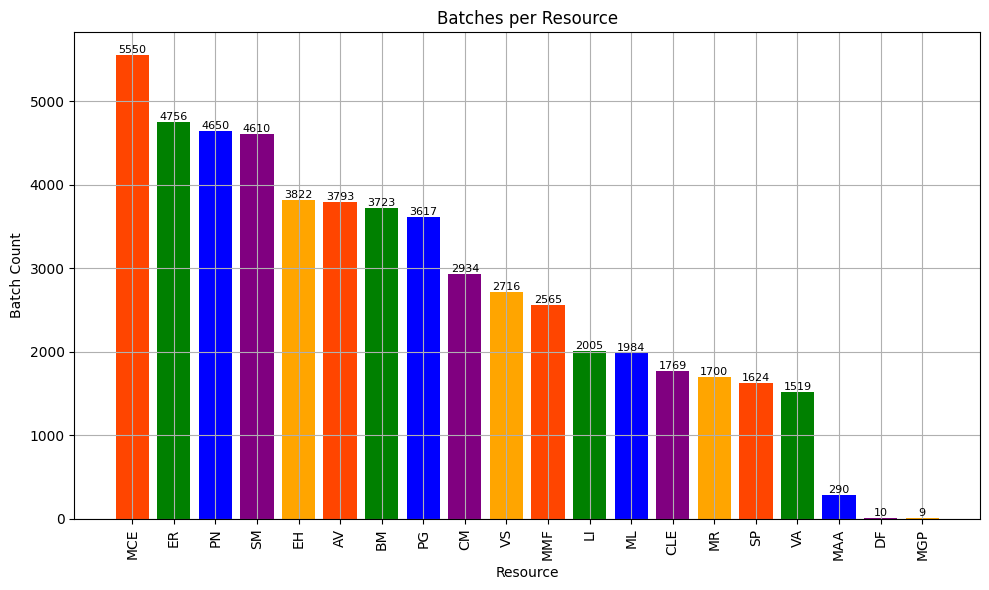

In [12]:
cypher_batches_per_resource = """
    MATCH (u:Resource)-[:CORR]->(n:BatchInstance)
    RETURN u.sysId AS resource, count(n) AS batch_count
    ORDER BY batch_count DESC
"""


def batches_per_resource(uri, username, password, cypher_batches_per_resource):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_batches_per_resource)
        data = result.data()
        return data
    
results_batches_per_resource = batches_per_resource(uri, username, password, cypher_batches_per_resource)
print(results_batches_per_resource) 

#Plot
resource = [str(row['resource']) for row in results_batches_per_resource]
batch_counts = [row['batch_count'] for row in results_batches_per_resource]

colors = ['orangered', 'green', 'blue', 'purple', 'orange']  # Add more colors as needed

plt.figure(figsize=(10, 6))
bars = plt.bar(resource, batch_counts, color=colors)

plt.title('Batches per Resource')
plt.xlabel('Resource')
plt.ylabel('Batch Count')

plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=10)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()


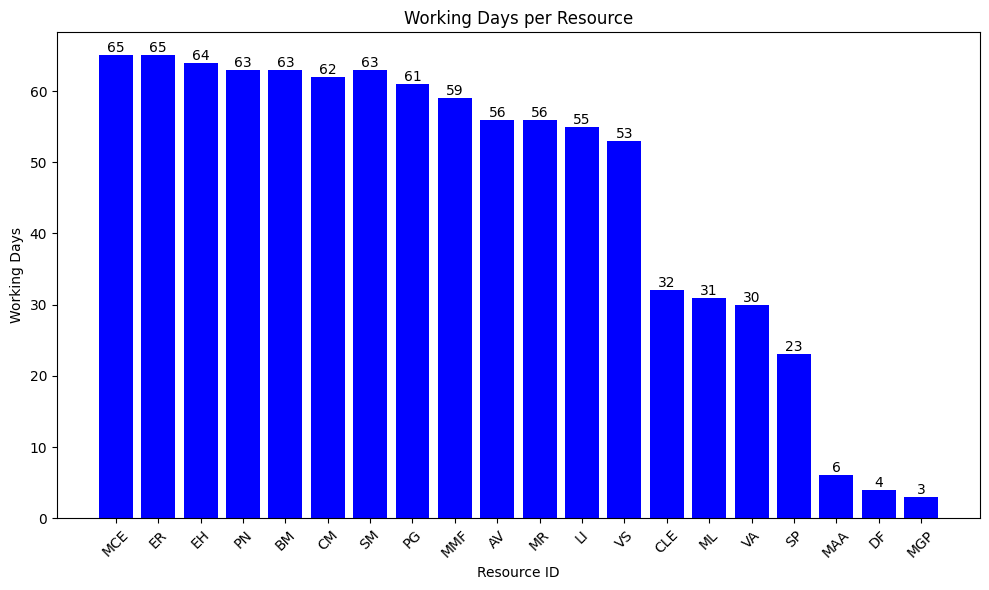

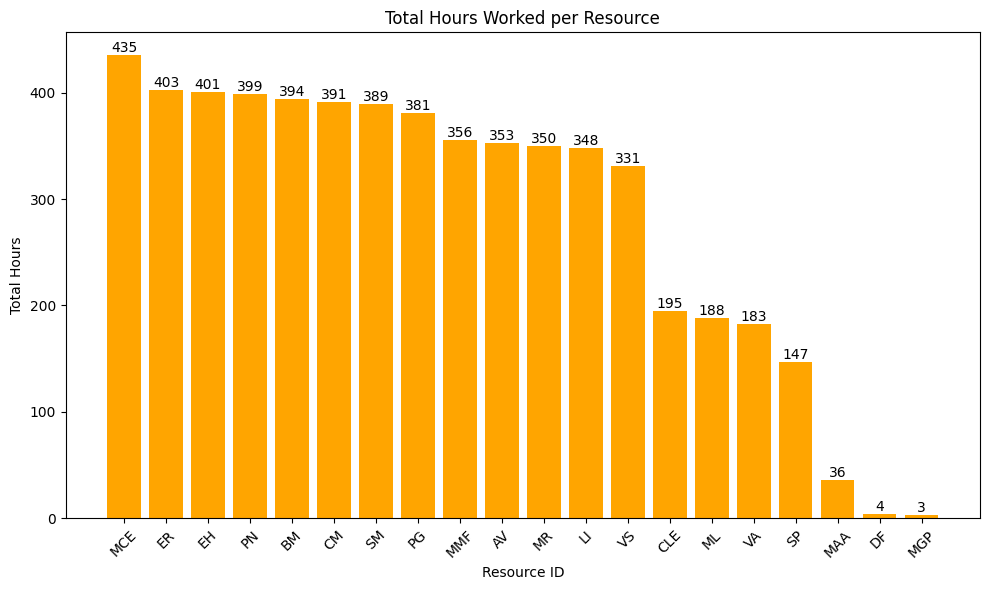

In [13]:

cypher_query = """
MATCH (u:Resource)<-[r:CORR]-(e:Event)
WITH u.sysId AS resource_id,
     date(e.timestamp) AS event_date,
     min(e.timestamp) AS start_time,
     max(e.timestamp) AS end_time
WITH resource_id, event_date, start_time, end_time,
     datetime(end_time).epochMillis - datetime(start_time).epochMillis AS duration_milliseconds
WITH resource_id, event_date, duration_milliseconds,
     CASE WHEN duration_milliseconds < 3600000 THEN 1 ELSE duration_milliseconds / 3600000 END AS duration_hours
RETURN resource_id,
       count(DISTINCT event_date) AS working_days,
       sum(duration_hours) AS total_hours
ORDER BY total_hours DESC
"""

def execute_cypher_query(uri, username, password, cypher_query):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_query)
        data = result.data()
        return data

# Execute the Cypher query
results = execute_cypher_query(uri, username, password, cypher_query)

# Extract resource IDs, working days, and total hours worked
resource_ids = [record['resource_id'] for record in results]
working_days = [record['working_days'] for record in results]
total_hours = [record['total_hours'] for record in results]

# Plotting the data for working days
plt.figure(figsize=(10, 6))
plt.bar(resource_ids, working_days, color='blue')
plt.xlabel('Resource ID')
plt.ylabel('Working Days')
plt.title('Working Days per Resource')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding values above the bars
for i in range(len(resource_ids)):
    plt.text(resource_ids[i], working_days[i], str(working_days[i]), ha='center', va='bottom')

plt.show()

# Plotting the data for total hours worked
plt.figure(figsize=(10, 6))
plt.bar(resource_ids, total_hours, color='orange')
plt.xlabel('Resource ID')
plt.ylabel('Total Hours')
plt.title('Total Hours Worked per Resource')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding values above the bars
for i in range(len(resource_ids)):
    plt.text(resource_ids[i], total_hours[i], str(total_hours[i]), ha='center', va='bottom')

plt.show()


